# Visual Transformer

[An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf)

##ViT

![alt text](https://drive.google.com/uc?export=view&id=1J5TvycDPs8pzfvlXvtO5MCFBy64yp9Fa)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None,
                 dropout=0.):
        super().__init__()
        self.lin1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.lin2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.act(self.lin1(x))
        x = self.lin2(x)
        x = self.dropout(x)
        return x

In [ ]:
from torch.nn.functional import softmax
 
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, attn_dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        self.scale = 1./(dim**0.5)
        self.qkv_gen = torch.nn.ModuleList()
        self.dim = dim
 
        # One matrix to generate query, key and value simultaneuosly
        self.attention_dim = dim//num_heads
        for head in range(num_heads):
            self.qkv_gen.append(torch.nn.Linear(dim, 3*self.attention_dim))
        self.linear_transformation = torch.nn.Linear(dim, dim)
        self.attn_dropout = nn.Dropout(attn_dropout)
 
    def forward(self, x):
        batch_size = x.shape[0]
        # batch x (H*W/(patch_size^2)+1) x embed_dim -> 
        # -> num_heads x batch x (H*W/(patch_size^2)+1) x attention_dim
        # print(self.qkv_gen[0](x))
        # print([self.qkv_gen[head_i](x) for head_i in range(self.num_heads)])
        qkv = torch.stack(
            [self.qkv_gen[head_i](x) for head_i in range(self.num_heads)])
        # Unpack qkv into q, k, v
        q, k, v =\
        qkv[:, :, :, :self.attention_dim],\
        qkv[:, :, :, self.attention_dim:2*self.attention_dim],\
        qkv[:, :, :, 2*self.attention_dim:]
 
        # Get attention score (MatMul and scale steps)
        # num_heads x batch x (H*W/(patch_size^2)+1) x attention_dim @
        # num_heads x batch x attention_dim x (H*W/(patch_size^2)+1) ->
        # -> num_heads x batch x (H*W/(patch_size^2)+1) x (H*W/(patch_size^2)+1)
        normalized_attention_score = (q@k.transpose(-2, -1))*self.scale
 
        # Get weights for attention (Softmax step)
        softmaxed_attention_score = softmax(normalized_attention_score, dim = -1)
 
        # num_heads x batch x (H*W/(patch_size^2)+1) x attention_dim
        result = softmaxed_attention_score @ v
 
        # num_heads x batch x (H*W/(patch_size^2)+1) x attention_dim ->
        # batch x (H*W/(patch_size^2)+1) x num_heads x attention_dim
        result = torch.permute(result, dims = (1, 2, 0, 3))
 
        # batch x (H*W/(patch_size^2)+1) x num_heads x attention_dim ->
        # batch x (H*W/(patch_size^2)+1) x embed_dim
        result = torch.reshape(result, (batch_size, -1, self.dim))
        x = self.linear_transformation(result)
        x = self.attn_dropout(x)
        return x

In [ ]:
class ImgPatches(nn.Module):
    def __init__(self, in_ch=3, embed_dim=768, patch_size=16):
        super().__init__()
        self.patch_embed = nn.Conv2d(in_ch, embed_dim, patch_size, patch_size)

    def forward(self, img):
        patches = self.patch_embed(img)
        patches = torch.flatten(patches, 2)
        patches = torch.transpose(patches, 2, 1)
        return patches

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4, drop_rate=0.):
        super().__init__()
        self.norm_pre = nn.LayerNorm(dim)
        self.attention = Attention(dim, attn_dropout = drop_rate, 
                                   num_heads = num_heads)
        self.mlp = MLP(dim, mlp_ratio*dim, dim, dropout = drop_rate)
        self.norm_pos = nn.LayerNorm(dim)
        

    def forward(self, x):
        xq = self.norm_pre(x)
        xq = self.attention(xq)
        x = xq + x
        xn = self.norm_pos(x)
        xn = self.mlp(xn)
        return x + xn

In [ ]:
class Transformer(nn.Module):
    def __init__(self, depth, dim, num_heads=8, mlp_ratio=4, drop_rate=0.):
        super().__init__()
        self.blocks = nn.ModuleList([
            Block(dim, num_heads, mlp_ratio, drop_rate)
            for i in range(depth)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
                 drop_rate=0.3):
        super().__init__()
        self.embed_dim = embed_dim
        self.img_patches = ImgPatches(in_ch=in_ch, embed_dim=embed_dim, patch_size=patch_size)
        self.cl = nn.Parameter(torch.ones((1, 1, embed_dim)))
        self.pos = nn.Parameter(torch.ones((1, 197, embed_dim)))
        self.transform = Transformer(depth, embed_dim, num_heads, 
                                     mlp_ratio, drop_rate)
        self.classifier = torch.nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.img_patches(x)
        x = torch.concat((x, self.cl.repeat(x.shape[0], 1, 1)), dim=1)
        x = x + self.pos.data
        x = self.transform(x)
        class_embeding = x[:, -1, :]
        class_embeding = self.classifier(class_embeding)
        
        return class_embeding

In [ ]:
a = torch.ones(1,3,224,224).cuda()
v = ViT().cuda()

b = v(a)

print(b.shape)

torch.Size([1, 1000])


# Work with Data

In [ ]:
import os
from glob import glob

Download

In [ ]:
! git clone https://github.com/Skuldur/Oxford-IIIT-Pets-Pytorch.git
!sudo mv 'Oxford-IIIT-Pets-Pytorch/datasets' '/content/'
!mkdir data/

Cloning into 'Oxford-IIIT-Pets-Pytorch'...
remote: Enumerating objects: 7374, done.
remote: Total 7374 (delta 0), reused 0 (delta 0), pack-reused 7374
Receiving objects: 100% (7374/7374), 753.77 MiB | 27.86 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (7398/7398), done.


Prepare

In [ ]:
dataset_classes = set()

filenames = glob('./datasets/images/*.jpg')

for image in filenames:
    class_name = image.rsplit("/")[3].rsplit('_', 1)[0]
    dataset_classes.add(class_name)

for dir_name in dataset_classes:
  try:
    os.mkdir('data/' + dir_name)
  except:
    print('Dir created')

root = ""
dir_name = "datasets/images/"
for root, dirs, files in os.walk(os.path.join(root, dir_name)):
  for file in files:
    image_name = os.path.join(root, file)
    class_name = image_name.rsplit("/")[2].rsplit('_', 1)[0]
    new_filename = image_name.rsplit("/")[2].rsplit('_', 1)[1]
    os.replace(image_name, "data/" + class_name + "/" + new_filename)

Split Dataset to train and val

In [ ]:
!rm -rf datasets
!pip install split-folders

import splitfolders
import glob, os, os.path

none_valid_picture = ['data/Abyssinian/34.jpg', 'data/Egyptian_Mau/167.jpg','data/Egyptian_Mau/177.jpg', 'data/Egyptian_Mau/191.jpg', 'data/Egyptian_Mau/145.jpg', 'data/Egyptian_Mau/139.jpg']

for f in none_valid_picture:
    os.remove(f)

splitfolders.ratio('data', output="datasets", seed=42, ratio=(.8, 0.2), group_prefix=None, move=False)

for name_class in dataset_classes:
  filelist = glob.glob(os.path.join("datasets/train/" + name_class + "/", "*.mat"))
  for f in filelist:
    os.remove(f)
  
  filelist = glob.glob(os.path.join("datasets/val/" + name_class + "/", "*.mat"))
  for f in filelist:
    os.remove(f)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 7387 files [00:02, 2669.20 files/s]


Count files in train dir

In [ ]:
absolute_path = 'datasets/train/'
dir_names = os.listdir(absolute_path)
counter = 0

for dir_name in dir_names:
  files_count = len([name for name in os.listdir(absolute_path + dir_name) if os.path.isfile(os.path.join(absolute_path + dir_name,name))])
  counter = counter + files_count
  print("Dir '" + dir_name + "' have " + str(files_count) + " files")

print(counter)

Dir 'miniature_pinscher' have 160 files
Dir 'leonberger' have 160 files
Dir 'american_bulldog' have 160 files
Dir 'samoyed' have 160 files
Dir 'Bengal' have 160 files
Dir 'japanese_chin' have 160 files
Dir 'Siamese' have 160 files
Dir 'wheaten_terrier' have 160 files
Dir 'Persian' have 160 files
Dir 'pug' have 160 files
Dir 'Birman' have 160 files
Dir 'Sphynx' have 160 files
Dir 'Abyssinian' have 159 files
Dir 'great_pyrenees' have 160 files
Dir 'Egyptian_Mau' have 156 files
Dir 'Maine_Coon' have 160 files
Dir 'shiba_inu' have 160 files
Dir 'newfoundland' have 160 files
Dir 'Ragdoll' have 160 files
Dir 'saint_bernard' have 160 files
Dir 'english_setter' have 160 files
Dir 'chihuahua' have 160 files
Dir 'Russian_Blue' have 160 files
Dir 'Bombay' have 160 files
Dir 'german_shorthaired' have 160 files
Dir 'pomeranian' have 160 files
Dir 'keeshond' have 160 files
Dir 'basset_hound' have 160 files
Dir 'havanese' have 160 files
Dir 'boxer' have 160 files
Dir 'staffordshire_bull_terrier' have

# Install and Import Libraies

In [ ]:
!pip install imgaug wandb
!pip install timm
!pip install imgaug -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 12.6 MB/s 
     |████████████████████████████████| 182 kB 64.1 MB/s 
     |████████████████████████████████| 166 kB 53.7 MB/s 
     |████████████████████████████████| 63 kB 381 kB/s 
     |████████████████████████████████| 166 kB 57.6 MB/s 
     |████████████████████████████████| 162 kB 58.1 MB/s 
     |████████████████████████████████| 162 kB 58.0 MB/s 
     |████████████████████████████████| 158 kB 58.9 MB/s 
     |████████████████████████████████| 157 kB 47.3 MB/s 
     |████████████████████████████████| 157 kB 61.8 MB/s 
     |████████████████████████████████| 157 kB 59.1 MB/s 
     |████████████████████████████████| 157 kB 54.8 MB/s 
     |████████████████████████████████| 157 kB 47.3 MB/s 
     |████████████████████████████████| 157 kB 52.9 MB/s 
     |████████████████████████████████| 157 kB 57.0 MB/s 
     |███████████████████████████

In [ ]:
import torch
import os
import cv2
import imgaug as ia
import numpy as np
import sys
import json

from imgaug import augmenters as iaa

from collections import defaultdict

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

from torchvision.models import resnet18 as resnet18
from torchvision.models import resnet34 as resnet34
from torchvision.models import resnext50_32x4d as resnext50_32x4d
from torchvision import transforms

import timm

import matplotlib.pyplot as plt

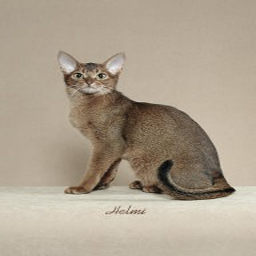

In [ ]:
import imageio
from imgaug import augmenters as iaa
import imgaug as ia

image_name = 'datasets/train/Abyssinian/11.jpg'

image = imageio.imread(image_name)

rotate = iaa.Resize({"height": 256, "width": 256})
        # iaa.Resize({"height": 224, "width": 224})
        #iaa.JpegCompression(compression=(62, 75)),
        #iaa.Grayscale(alpha=(0.0, 1.0)),
image_aug = rotate(image=image)

rotate = iaa.Grayscale(alpha=(0.0, 0.8))
        # iaa.Resize({"height": 224, "width": 224})
        #iaa.JpegCompression(compression=(62, 75)),
        #iaa.Grayscale(alpha=(0.0, 1.0)),
image_aug = rotate(image=image_aug)

im_rgb = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)

from google.colab.patches import cv2_imshow
cv2_imshow(im_rgb)

# Config

In [ ]:
BATCH_SIZE = 64
TRAIN_LEN = 0
TEST_LEN = 0
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
NUM_WORKERS = 4
EPOCHS = 60
DEVICE = 'cuda'
SEED = 2022
SPLIT_DATA = 0.2
LR = 0.00379856
EMBED_DIM = 36
NUM_HEADS = 4
DEPTH = 8
DROPOUT = 0.3

MODEL_DESC = ''

TRAIN_DATA_PATH = 'datasets/train/'
TEST_DATA_PATH = 'datasets/val/'

# DatasetRAM

In [ ]:
class DatasetRAM(Dataset):

    def __init__(self, path, transform=None):
        super().__init__()

        self.path = path
        self.transform = transform

        self.data = []

        self.class_name_to_idx = {}
        self.idx_to_class_name = []

        for class_idx, class_name in enumerate(sorted(os.listdir(path))):
            self.class_name_to_idx[class_name] = class_idx
            self.idx_to_class_name.append(class_name)

            #print("Class: {} , id: {}".format(class_name,class_idx))

            class_images_path = os.path.join(path, class_name)
            for image_name in os.listdir(class_images_path):
                image_path = os.path.join(class_images_path, image_name)
                
                # считывание с диска и декодирование jpeg данных
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                
                self.data.append((image, class_name))
        
        #print(self.class_name_to_idx)
        #print('----------------')
        #print(self.idx_to_class_name)

    def __getitem__(self, idx):
        image, class_name = self.data[idx]
        
        if self.transform:
          image = self.transform(image)
        
        return image, self.class_name_to_idx[class_name]

    def __len__(self):
        return len(self.data)

# Data preparation

In [ ]:
artifact_augmentation = iaa.meta.OneOf([
        iaa.imgcorruptlike.Pixelate(severity=1),
        iaa.imgcorruptlike.JpegCompression(severity=1),
        iaa.imgcorruptlike.Brightness(severity=1),
        iaa.imgcorruptlike.MotionBlur(severity=1),
        iaa.imgcorruptlike.ShotNoise(severity=1),
        iaa.GammaContrast((0.5, 2.0)),
        iaa.meta.Identity()])

In [ ]:
train_transform = transforms.Compose([
    iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Grayscale(alpha=(0.0, 0.8)),
        iaa.Rot90((1, 3)),
        iaa.Cutout(fill_mode="gaussian", fill_per_channel=0.5, size=0.10),
        iaa.Flipud(0.5),
        iaa.Resize({"height": IMAGE_HEIGHT, "width": IMAGE_WIDTH})
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    iaa.Sequential([
        iaa.Resize({"height": IMAGE_HEIGHT, "width": IMAGE_WIDTH})
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
train_dataset = DatasetRAM(TRAIN_DATA_PATH, train_transform)
test_dataset = DatasetRAM(TEST_DATA_PATH, test_transform)

TRAIN_LEN = len(train_dataset)
TEST_LEN = len(test_dataset)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

Train dataset size: 5906
Test dataset size: 1478


In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # обучающие данные стоит передавать в случайном порядке
    num_workers=NUM_WORKERS,  # число потоков подготовки данных. если не удается полностью задействовать GPU, то можно попробовать увеличить, но это увеличит нагрузку на cpu
    pin_memory=True,  # перевод GPU памяти в режим pinned ускоряет загрузку/выгрузку данных
    drop_last=True  # чтобы все батчи были одного размера, лучше сделать True
)

test_dataloader = DataLoader(
    test_dataset,  
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=NUM_WORKERS, 
    pin_memory=True, 
    drop_last=False  # чтобы обработать все тестовые данные
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model initialization

In [ ]:
model = ViT(embed_dim = EMBED_DIM, num_classes=37, num_heads = NUM_HEADS, 
            depth = DEPTH, drop_rate = DROPOUT)

torch.nn.init.xavier_normal_(model.classifier.weight)

Parameter containing:
tensor([[ 0.1290,  0.3012, -0.0007,  ...,  0.0053, -0.1926,  0.1387],
        [ 0.2446, -0.3379, -0.1659,  ..., -0.0541, -0.0227, -0.0312],
        [-0.1513,  0.2566, -0.3705,  ...,  0.1699, -0.0080, -0.2514],
        ...,
        [-0.0285,  0.3393, -0.0550,  ..., -0.2871,  0.1036, -0.2137],
        [-0.1357,  0.2915,  0.4221,  ..., -0.2964,  0.0492, -0.1135],
        [-0.1033,  0.0881, -0.1090,  ..., -0.0495, -0.0423,  0.0542]],
       requires_grad=True)

In [ ]:
print('Total number of parameters:', sum(param.numel() for param in model.parameters()))

Total number of parameters: 164341


In [ ]:
print('Number of trainable parameters:', sum(param.numel() for param in model.parameters() if param.requires_grad))

Number of trainable parameters: 164341


In [ ]:
if torch.cuda.is_available():
  print('true')
  model = model.cuda()

# Training

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

В качестве показателя качества будем использовать точность классификации (accuracy). Результаты её вычисления будем отправлять на wandb сервер

In [ ]:
dataset_tuple = ('British_Shorthair',
 'german_shorthaired',
 'Abyssinian',
 'yorkshire_terrier',
 'english_setter',
 'chihuahua',
 'scottish_terrier',
 'miniature_pinscher',
 'Russian_Blue',
 'english_cocker_spaniel',
 'american_bulldog',
 'pug',
 'havanese',
 'leonberger',
 'great_pyrenees',
 'american_pit_bull_terrier',
 'staffordshire_bull_terrier',
 'Sphynx',
 'Egyptian_Mau',
 'Maine_Coon',
 'pomeranian',
 'samoyed',
 'beagle',
 'newfoundland',
 'wheaten_terrier',
 'Siamese',
 'Ragdoll',
 'japanese_chin',
 'keeshond',
 'Bombay',
 'boxer',
 'Persian',
 'shiba_inu',
 'saint_bernard',
 'basset_hound',
 'Birman',
 'Bengal')

In [ ]:
import wandb

def metrics_wb(dataloader, model, label_name):
    model = model.eval()
    tp = 0

    my_classes = dataset_tuple
    
    correct_pred = {classname: 0 for classname in my_classes}
    total_pred = {classname: 0 for classname in my_classes}

    with torch.no_grad():
        tracker = tqdm(dataloader, total=len(dataloader))
        for batch in tracker:
            image_batch, class_idx_batch = batch
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                #class_idx_batch = torch.nn.functional.one_hot(class_idx_batch, num_classes = 37)
                class_idx_batch = class_idx_batch.cuda()
            
            logits = model(image_batch)
            classes = torch.argmax(logits, dim=1)
            tp += (class_idx_batch == classes).sum().item()

            for label, prediction in zip(class_idx_batch.cpu(), classes.cpu()):
              if label == prediction:
                correct_pred[my_classes[label]] += 1
              total_pred[my_classes[label]] += 1

        acc = tp / len(dataloader.dataset)
        averange_acc = label_name + '_accuracy'
        wandb.log({averange_acc: acc})
        print(averange_acc, acc)

        recall_classes_dict = {}

        for classname, correct_count in correct_pred.items():
          recall = float(correct_count) / total_pred[classname]
          recall_class = label_name + '/recall_' + classname
          if label_name == 'Test': wandb.log({recall_class: recall})
          print(f'Recall for class: {classname:5s} is {recall}')
          recall_classes_dict[classname] = recall
    
    return acc, recall_classes_dict

Запустим процесс обучения

In [ ]:
from tqdm import tqdm_notebook as tqdm
import os
import json

def train(model, num_epochs, prefix):
    
    wandb.init(project="vit-project", entity="vit-reserchers", config={
    "TRAIN_LEN": TRAIN_LEN,
    "TEST_LEN": TEST_LEN,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "IMAGE_WIDTH": IMAGE_WIDTH,
    "IMAGE_HEIGHT": IMAGE_HEIGHT,
    "NUM_WORKERS": NUM_WORKERS,
    "SPLIT_DATA": SPLIT_DATA,
    "LR": LR,
    "MODEL_DESC": MODEL_DESC,
    "BATCH_SIZE": BATCH_SIZE,
    "EMBED_DIM": EMBED_DIM,
    "NUM_HEADS": NUM_HEADS,
    "DEPTH": DEPTH,
    "DROPOUT": DROPOUT
    })

    wandb.watch(model)

    my_classes = dataset_tuple

    best_recall = {}

    best_accuracy = 0

    for class_name in my_classes:
      best_recall[class_name] = 0

    for epoch in range(num_epochs):
        print('\nEpoch', epoch)
        model = model.train()

        loss_epoch = []

        tracker = tqdm(train_dataloader, total=len(train_dataloader))
        for batch in tracker:
            # в pytorch градиент хранится в переменной grad и вычисляется при вызове backward
            # при этом он не перезаписывается, а добавляется к старому значению,
            # поэтому необходимо приравнять grad нулю, перед вычислением градиентов
            optimizer.zero_grad()
            
            image_batch, class_idx_batch = batch
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                class_idx_batch = class_idx_batch.cuda()
                # Denis OHE
                #class_idx_batch = torch.nn.functional.one_hot(class_idx_batch, num_classes = 37)
                #class_idx_batch = class_idx_batch.cuda()

            logits = model(image_batch)

            # вычисляем функцию потерь
            #print(class_idx_batch)
            loss = F.cross_entropy(logits, class_idx_batch)

            # вычисляем градиенты
            loss.backward()

            wandb.log({'Batch_train_loss': loss})

            loss_epoch.append(loss.detach().flatten()[0])

            # выполняем шаг оптимизации - обновляем веса
            optimizer.step()

        # считаем и логируем метрики качества
        train_metrics = metrics_wb(train_dataloader, model, 'Train')
        test_metrics = metrics_wb(test_dataloader, model, 'Test')

        wandb.log({'Epoch_train_loss': sum(loss_epoch)/len(loss_epoch)})

        if test_metrics[0] > best_accuracy:
          print('\nBest accuracy in Epoch №', epoch)
          print('\nAverange accuracy: ', test_metrics[0])
          
          #best_recall = test_metrics[1]
          best_accuracy = test_metrics[0]
          
          torch.save(model.state_dict(), prefix + 'model.pth')
          torch.save(optimizer.state_dict(), prefix + 'optimizer.pth')
          #torch.save(model.state_dict(),'gdrive/MyDrive/model/' + prefix + 'model.pth')
          #torch.save(optimizer.state_dict(),'gdrive/MyDrive/model/' + prefix + 'optimizer.pth')

In [ ]:
prefix = 'ViT' + '_our_' + str(EPOCHS) + 'epoch_'
MODEL_DESC = 'Use our ViT on 1 stage with 4 aug: Fliplr, Flipud, CutOut and Rot90'
train(model, EPOCHS, prefix)

Clear memory

In [ ]:
import gc

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Tue Oct 25 14:48:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |   1594MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Additional training

In [ ]:
# ViT(embed_dim = EMBED_DIM, num_classes=37)
pretrained = ViT(embed_dim = EMBED_DIM, num_classes=37, num_heads = NUM_HEADS, 
            depth = DEPTH, drop_rate = DROPOUT)
#torch.nn.init.xavier_normal_(pretrained.head.weight)
pretrained.load_state_dict(torch.load('ViT_our_2stage_60epoch_model.pth'))
pretrained.cuda()

---
If you need to change the learning rate

In [ ]:
sd = optimizer.state_dict()
sd['param_groups'][0]['lr'] = 0.0005
optimizer.load_state_dict(sd)
LR = 0.0005

# and comment down optimizer

---

In [ ]:
LR = 0.00452560
optimizer = torch.optim.Adam(pretrained.parameters(), lr=LR)

In [ ]:
prefix = 'ViT' + '_our_3stage_' + str(EPOCHS) + 'epoch_'
MODEL_DESC = 'Use our ViT on 3 stage with 5 aug and new LR: Fliplr, Flipud, CutOut, Grayscale and Rot90'
train(pretrained, EPOCHS, prefix)

Batch_train_loss,▇▆▆▆▄▅▅▅▇▄▄▅▇▅▅▅▆▄█▅▃▄▄▅▄▅▄▃▃▃▅▁▃▂▄▅▄▅▁▂
Epoch_train_loss,█▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▁▁
Test/recall_Abyssinian,▂▄▁▄▅▃▃█▅▄█▅▅▄▆▁▅▃▅▃▅▄▄▆▅▃▃▇▅▄▁▅▁▄▆▆▄▆▄▃
Test/recall_Bengal,█▁▆▆▇▄▄▃▄▆▃▃▃▆▅▄▅▂▅▃▄▆▅▃▄▃▆▄▅▄▅▄▃▇▆▆▄▃▅▄
Test/recall_Birman,▅▄▄▃▃▂█▂▃▁▂▂▄▂▂▅▁▆▄▅▄▂▂▄▃▃▄▄▂▃█▅▁▂█▄▂▁▅▂
Test/recall_Bombay,▅▂▃▅▁▃▃▃▃▆▅▆▅█▅▅▅▂▆▆▆▄▄▂▁▄▄▃▄▄▄▃▃▄▂▄▅▃▅▇
Test/recall_British_Shorthair,▁▅▃▃▁▅▄▇▂▇▂▅█▅▅▃▃▂▃▆▅▂▃▆▆▃▄▃▄▂▄▆▅▅▃▃▄▂▅▂
Test/recall_Egyptian_Mau,▇▃▃▂▇▂▁▄▄▅▄▄▄▄▄▆▄█▄▇▄▃▅█▂▆▃▇▄▆▄▄▅▆▃▅▄▃▅▇
Test/recall_Maine_Coon,▃▃▂▅▃▃▃▂▂▂▄▂▃▂▃▁▂▁▅▅▃▂▅▁▃▇▃▁▂▆▂▇▁▄▅▄▅▃█▃
Test/recall_Persian,▂█▄▁▇▇▄▄▇▇▂▃▅▃▅▄█▇▁▄▅▂▄▄▇▂▇▂▃▅▄▇▆▅▇▆▆▄▇▃
Test/recall_Ragdoll,▅▅▅▅▄▇█▆▆▅▆▆█▆▆▅▆▄▄▆▆▆▂▃▅▄▅▃▆▄▃▁▇▆▂▃▅▆▆▇



Epoch 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/92 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/92 [00:00<?, ?it/s]

Train_accuracy 0.5907551642397562
Recall for class: British_Shorthair is 0.48427672955974843
Recall for class: german_shorthaired is 0.8
Recall for class: Abyssinian is 0.475
Recall for class: yorkshire_terrier is 0.85
Recall for class: english_setter is 0.51875
Recall for class: chihuahua is 0.7419354838709677
Recall for class: scottish_terrier is 0.4810126582278481
Recall for class: miniature_pinscher is 0.58125
Recall for class: Russian_Blue is 0.69375
Recall for class: english_cocker_spaniel is 0.75625
Recall for class: american_bulldog is 0.4875
Recall for class: pug   is 0.7358490566037735
Recall for class: havanese is 0.620253164556962
Recall for class: leonberger is 0.43125
Recall for class: great_pyrenees is 0.7452229299363057
Recall for class: american_pit_bull_terrier is 0.425
Recall for class: staffordshire_bull_terrier is 0.56875
Recall for class: Sphynx is 0.3875
Recall for class: Egyptian_Mau is 0.5126582278481012
Recall for class: Maine_Coon is 0.5157232704402516
Recall

  0%|          | 0/24 [00:00<?, ?it/s]

Test_accuracy 0.2307171853856563
Recall for class: British_Shorthair is 0.15
Recall for class: german_shorthaired is 0.3
Recall for class: Abyssinian is 0.3
Recall for class: yorkshire_terrier is 0.525
Recall for class: english_setter is 0.125
Recall for class: chihuahua is 0.358974358974359
Recall for class: scottish_terrier is 0.075
Recall for class: miniature_pinscher is 0.25
Recall for class: Russian_Blue is 0.475
Recall for class: english_cocker_spaniel is 0.35
Recall for class: american_bulldog is 0.15
Recall for class: pug   is 0.25
Recall for class: havanese is 0.175
Recall for class: leonberger is 0.075
Recall for class: great_pyrenees is 0.25
Recall for class: american_pit_bull_terrier is 0.2
Recall for class: staffordshire_bull_terrier is 0.175
Recall for class: Sphynx is 0.075
Recall for class: Egyptian_Mau is 0.2
Recall for class: Maine_Coon is 0.125
Recall for class: pomeranian is 0.125
Recall for class: samoyed is 0.175
Recall for class: beagle is 0.2
Recall for class: n

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

Train_accuracy 0.5745005079580088
Recall for class: British_Shorthair is 0.3270440251572327
Recall for class: german_shorthaired is 0.75
Recall for class: Abyssinian is 0.5157232704402516
Recall for class: yorkshire_terrier is 0.6226415094339622
Recall for class: english_setter is 0.6477987421383647
Recall for class: chihuahua is 0.6774193548387096
Recall for class: scottish_terrier is 0.6
Recall for class: miniature_pinscher is 0.6729559748427673
Recall for class: Russian_Blue is 0.66875
Recall for class: english_cocker_spaniel is 0.6540880503144654
Recall for class: american_bulldog is 0.45
Recall for class: pug   is 0.6226415094339622
Recall for class: havanese is 0.5189873417721519
Recall for class: leonberger is 0.310126582278481
Recall for class: great_pyrenees is 0.71875
Recall for class: american_pit_bull_terrier is 0.48125
Recall for class: staffordshire_bull_terrier is 0.6
Recall for class: Sphynx is 0.3875
Recall for class: Egyptian_Mau is 0.4591194968553459
Recall for class

  0%|          | 0/24 [00:00<?, ?it/s]

Test_accuracy 0.2090663058186739
Recall for class: British_Shorthair is 0.05
Recall for class: german_shorthaired is 0.325
Recall for class: Abyssinian is 0.3
Recall for class: yorkshire_terrier is 0.35
Recall for class: english_setter is 0.225
Recall for class: chihuahua is 0.358974358974359
Recall for class: scottish_terrier is 0.125
Recall for class: miniature_pinscher is 0.25
Recall for class: Russian_Blue is 0.4
Recall for class: english_cocker_spaniel is 0.225
Recall for class: american_bulldog is 0.15
Recall for class: pug   is 0.25
Recall for class: havanese is 0.175
Recall for class: leonberger is 0.025
Recall for class: great_pyrenees is 0.325
Recall for class: american_pit_bull_terrier is 0.15
Recall for class: staffordshire_bull_terrier is 0.1
Recall for class: Sphynx is 0.1
Recall for class: Egyptian_Mau is 0.125
Recall for class: Maine_Coon is 0.075
Recall for class: pomeranian is 0.15
Recall for class: samoyed is 0.125
Recall for class: beagle is 0.2
Recall for class: ne

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

Train_accuracy 0.5384354893328818
Recall for class: British_Shorthair is 0.5031446540880503
Recall for class: german_shorthaired is 0.83125
Recall for class: Abyssinian is 0.535031847133758
Recall for class: yorkshire_terrier is 0.725
Recall for class: english_setter is 0.5723270440251572
Recall for class: chihuahua is 0.6923076923076923
Recall for class: scottish_terrier is 0.39375
Recall for class: miniature_pinscher is 0.50625
Recall for class: Russian_Blue is 0.6624203821656051
Recall for class: english_cocker_spaniel is 0.65625
Recall for class: american_bulldog is 0.54375
Recall for class: pug   is 0.59375
Recall for class: havanese is 0.45625
Recall for class: leonberger is 0.26875
Recall for class: great_pyrenees is 0.6375
Recall for class: american_pit_bull_terrier is 0.325
Recall for class: staffordshire_bull_terrier is 0.44025157232704404
Recall for class: Sphynx is 0.4125
Recall for class: Egyptian_Mau is 0.4025157232704403
Recall for class: Maine_Coon is 0.26875
Recall for

  0%|          | 0/24 [00:00<?, ?it/s]

Test_accuracy 0.2165087956698241
Recall for class: British_Shorthair is 0.025
Recall for class: german_shorthaired is 0.425
Recall for class: Abyssinian is 0.425
Recall for class: yorkshire_terrier is 0.4
Recall for class: english_setter is 0.2
Recall for class: chihuahua is 0.38461538461538464
Recall for class: scottish_terrier is 0.1
Recall for class: miniature_pinscher is 0.325
Recall for class: Russian_Blue is 0.4
Recall for class: english_cocker_spaniel is 0.25
Recall for class: american_bulldog is 0.2
Recall for class: pug   is 0.25
Recall for class: havanese is 0.125
Recall for class: leonberger is 0.05
Recall for class: great_pyrenees is 0.175
Recall for class: american_pit_bull_terrier is 0.1
Recall for class: staffordshire_bull_terrier is 0.1
Recall for class: Sphynx is 0.0
Recall for class: Egyptian_Mau is 0.125
Recall for class: Maine_Coon is 0.075
Recall for class: pomeranian is 0.225
Recall for class: samoyed is 0.075
Recall for class: beagle is 0.2
Recall for class: newf

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp ViT_our_60epoch_model.pth gdrive/MyDrive/ViT/
#!cp ViT_our_2stage_40epoch_model.pth gdrive/MyDrive/ViT/
#!cp ViT_our_3stage_40epoch_model.pth gdrive/MyDrive/ViT/